# Dependencies

In [1]:
!pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [101]:
import os

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import gensim.downloader as api

from itertools import permutations

from gensim.utils import tokenize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords

from tqdm import tqdm

os.environ["GENSIM_DATA_DIR"] = '.\\gensim'

# Loading Data

In [102]:
df_train = pd.read_csv('./data/learn-ai-bbc/BBC News Train.csv')
df_test = pd.read_csv('./data/learn-ai-bbc/BBC News Test.csv')

In [107]:
df_train, df_eval = train_test_split(df_train, test_size=0.2)

In [108]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 893 entries, 737 to 1449
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  893 non-null    int64 
 1   Text       893 non-null    object
 2   Category   893 non-null    object
dtypes: int64(1), object(2)
memory usage: 27.9+ KB


In [109]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


In [110]:
df_train.head()

,ArticleId,Text,Category
737,1860,camera phones are must-haves four times more...,tech
626,832,muslims discuss election concerns issues that ...,politics
888,1215,toxic web links help virus spread virus writer...,tech
812,858,sella wants michalak recall former france cent...,sport
266,1598,survey confirms property slowdown government f...,business


In [111]:
df_test.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


# PreProcessing

To begin with , let's create a mapping of the different categories to indices

In [112]:
categories = df_train['Category'].unique()
categories = dict(zip(range(len(categories)), categories))
reverse_categories = {v:k for k,v in categories.items()}

Filtering out stop words since they are not as relavant for classification

In [124]:
df_train['text_clean'] = df_train['Text'].apply(lambda s: remove_stopwords(s))
df_test['text_clean'] = df_test['Text'].apply(lambda s: remove_stopwords(s))
df_eval['text_clean'] = df_eval['Text'].apply(lambda s: remove_stopwords(s))

We'll use bag of words count followed by TF-IDF

In [134]:
counter = CountVectorizer()
tfidf = TfidfTransformer()

bow_vec = counter.fit_transform(df_train['text_clean'])
tfidf_vec = tfidf.fit_transform(bow_vec)

bow_vec_eval = counter.transform(df_eval['text_clean'])
tfidf_vec_eval = tfidf.transform(bow_vec_eval)

In [115]:
vocab = counter.vocabulary_
reverse_vocab = {v:k for (k,v) in vocab.items()}

In [116]:
# Sanity
#print(list(map(lambda x: reverse_vocab[x], np.where(bow_vec[0].todense() > 0)[1])))
#print(df_train['text_clean'].iloc[0])

# EDA

Summing up the rows of our word count matrix to get the total word count in the dataset

In [117]:
word_counts_total = bow_vec.sum(axis=0)
word_frequencies = [(reverse_vocab[i],word_counts_total[0,i]) for i in range(len(vocab))]

Let's see which words are the most popular

In [118]:
top_words = pd.DataFrame(sorted(word_frequencies, key=lambda x:x[1], reverse=True), columns=['word','frequency'])
top_words

,word,frequency
0,said,2923
1,mr,1151
2,year,911
3,new,821
4,people,746
...,...,...
19663,zones,1
19664,zooms,1
19665,zooropa,1
19666,zuluaga,1


And how is the word count distributed? We have to log-transform for the visualization to make sense

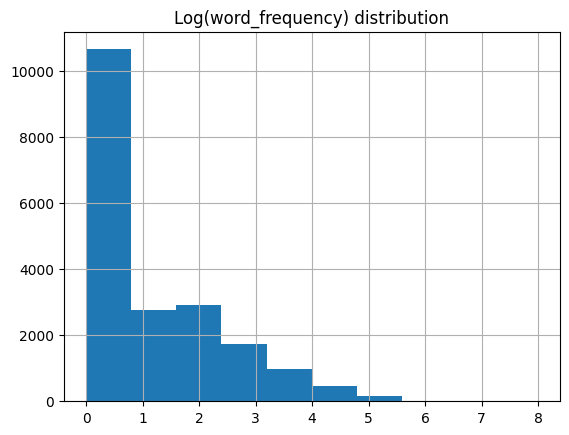

In [119]:

top_words['frequency'].apply(np.log).hist()
plt.title("Log(word_frequency) distribution")
plt.show()

# Supervised Approach

In order to represent our documents as vectors, we will utilize word2vec and get the mean vector for each document

In [21]:
wv = api.load('word2vec-google-news-300')

[==================--------------------------------] 38.0% 631.2/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[====================------------------------------] 41.0% 681.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=============================---------------------] 58.7% 975.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===============================-------------------] 62.1% 1033.1/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[================================================--] 97.5% 1621.7/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [120]:
def doc_embedding(text):
	tokens = tokenize(text)
	return np.mean([wv[t] for t in tokens if t in wv], axis=0)

# test_doc = df_train['text_clean'].iloc[0]
# print(test_doc)
# doc_embedding(test_doc)

We create our utility matrix both for training and testing datasets, retrieving all documents embeddings

In [125]:
util_matrix_train = np.zeros((len(df_train), wv.vector_size))
util_matrix_test = np.zeros((len(df_test), wv.vector_size))
util_matrix_eval = np.zeros((len(df_eval), wv.vector_size))

for i,doc in tqdm(enumerate(df_train['text_clean'])):
    util_matrix_train[i] = doc_embedding(doc)


util_matrix_eval = np.zeros((len(df_eval), wv.vector_size))
for i,doc in tqdm(enumerate(df_eval['text_clean'])):
    util_matrix_eval[i] = doc_embedding(doc)
    
util_matrix_test = np.zeros((len(df_test), wv.vector_size))
for i,doc in tqdm(enumerate(df_test['text_clean'])):
    util_matrix_test[i] = doc_embedding(doc)

893it [00:01, 533.95it/s]
224it [00:00, 586.24it/s]
735it [00:01, 526.04it/s]


In [127]:
print(util_matrix_train.shape)
print(util_matrix_eval.shape)
print(util_matrix_test.shape)

(893, 300)
(224, 300)
(735, 300)


Now we can train a model using supervised learning approaches, let's try KNN

Since we're using word2vec it is better to consider cosine distance metric

In [128]:
model = KNeighborsClassifier(n_neighbors=10, metric='cosine')

In [129]:
model.fit(util_matrix_train, y=df_train['Category'].map(reverse_categories))

KNeighborsClassifier(metric='cosine', n_neighbors=10)

In [130]:
predicted_labels = model.predict(util_matrix_train)

In [131]:
def find_perm(predicted_labels, df):
    best_acc = 0
    best_perm = None
    
    for perm in permutations(categories.values()):
        reverse_categories = {v:k for k,v in enumerate(perm)}
        true_labels = df['Category'].map(reverse_categories)
        acc = accuracy_score(predicted_labels, true_labels)
    
        if acc > best_acc:
            best_perm = perm
            best_acc = acc

    return best_acc, best_perm

In [132]:
    
best_acc, best_perm = find_perm(predicted_labels, df_train)

print(best_acc)
print(best_perm)

0.9585666293393057
('tech', 'politics', 'sport', 'business', 'entertainment')


In [133]:
predicted_labels = model.predict(util_matrix_eval)
find_perm(predicted_labels, df_eval)

(0.9464285714285714,
 ('tech', 'politics', 'sport', 'business', 'entertainment'))

# Unsupervised Approach

In [138]:
nmf_model = NMF(n_components=len(categories))

nmf_model.fit(tfidf_vec)
W_train = nmf_model.transform(tfidf_vec)
W_eval = nmf_model.transform(tfidf_vec_eval)
H = nmf_model.components_

In [139]:
predicted_train = np.argmax(W_train, axis=1)
predicted_eval = np.argmax(W_eval, axis=1)

In [140]:
find_perm(predicted_train, df_train)

(0.9126539753639418,
 ('sport', 'politics', 'tech', 'entertainment', 'business'))

In [141]:
find_perm(predicted_eval, df_eval)

(0.90625, ('sport', 'politics', 'tech', 'entertainment', 'business'))

# Interpretation

It seems like both the supervised and unsupervised approaches yielded pretty good performance in the training set, although the supervised approached using word2vec did perform better. Using NMF we couldn't utilize the power of word embeddings because the embedding vectors contain negative values.